# Plotting WXT and KLAF data using MetPy
In this notebook, we'll create a meteogram from the WXT data that we collected in 7-21 October 2021 on the Hampton Hall roof. 
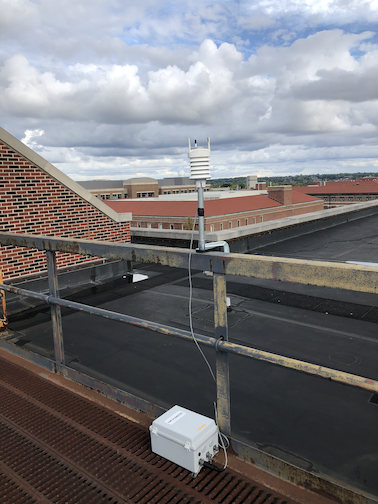
Be sure you're using your EAPS 227 kernel.

Place your data file (.CSV format) into the same directory/folder as this notebook.

Preamble (which you may need to execute twice):

In [1]:
# Plots will appear in this notebook
%matplotlib inline
# Suppress most (but not all) warnings
import warnings
warnings.simplefilter('ignore') 
# Other import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metpy.units import units
import scipy.stats as stats

# Use Pandas to read the WXT file into a dataframe.

In [2]:
fileName = 'EAPS227_20211006.csv'
wxt = pd.read_csv(fileName, header=[2], skiprows = [3], parse_dates=[0], infer_datetime_format=True, na_values = ['  '])

# Examine the contents.

In [3]:
wxt

,Date/Time,WindDir,WindSp,AirTemp,RH,BP,RainInten
0,2021-10-07 20:50:00,18,0.3,68.0,60,29.3,0.0
1,2021-10-07 21:00:00,129,3.6,71.7,69,29.3,0.0
2,2021-10-07 21:10:00,149,1.2,73.7,65,29.3,0.0
3,2021-10-07 21:20:00,116,5.6,73.9,64,29.3,0.0
4,2021-10-07 21:30:00,92,3.9,73.7,62,29.3,0.0
...,...,...,...,...,...,...,...
1998,2021-10-21 17:50:00,277,4.2,54.8,63,29.2,0.0
1999,2021-10-21 18:00:00,267,7.1,54.5,63,29.2,0.0
2000,2021-10-21 18:10:00,269,7.0,54.3,63,29.2,0.0
2001,2021-10-21 18:20:00,13,0.4,57.9,60,29.2,0.0


# We have about two weeks' worth of data here, at 10-minute intervals. 

Units are mostly Imperial, but we can use the units registry in MetPy to fix that.

Create a units attribute dictionary, as we did for the METAR data. <B>Make sure the units match the contents of your dataframe.</B>

In [4]:
wxt.units = {
    'Date/Time' : None,
    'WindDir' : 'degrees',
    'WindSp' : 'mph',
    'AirTemp' : 'degF',
    'RH' : None,
    'BP' : 'inHg',
    'RainInten': 'inches/hour'
}

# Since dewpoint was not recorded, we need to calculate it. 

A quick search of the MetPy documentation reveals that the function we need is dewpoint_from_relative_humidity: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint_from_relative_humidity.html

It takes air temperature and relative humidity, and returns dewpoint.

Note that we have to divide the relative humidity by 100 because it's reported in %, and we've specified its units as 'None' (i.e. unitless).

# Pro tip: If you want to read the documentation for a particular function, type the function name followed by "?"
Click the "X" to close the documentation pane.

In [5]:
from metpy.calc import dewpoint_from_relative_humidity
dewpoint_from_relative_humidity?

In [6]:
# Add Dewpoint to our dataframe:
wxt['Dewpoint'] = dewpoint_from_relative_humidity(wxt['AirTemp'].values.squeeze() * units(wxt.units['AirTemp']), \
                                                 wxt['RH'].values.squeeze()/100. * units(wxt.units['RH']))
wxt

,Date/Time,WindDir,WindSp,AirTemp,RH,BP,RainInten,Dewpoint
0,2021-10-07 20:50:00,18,0.3,68.0,60,29.3,0.0,12.006808
1,2021-10-07 21:00:00,129,3.6,71.7,69,29.3,0.0,16.110036
2,2021-10-07 21:10:00,149,1.2,73.7,65,29.3,0.0,16.232131
3,2021-10-07 21:20:00,116,5.6,73.9,64,29.3,0.0,16.094479
4,2021-10-07 21:30:00,92,3.9,73.7,62,29.3,0.0,15.493365
...,...,...,...,...,...,...,...,...
1998,2021-10-21 17:50:00,277,4.2,54.8,63,29.2,0.0,5.808631
1999,2021-10-21 18:00:00,267,7.1,54.5,63,29.2,0.0,5.650766
2000,2021-10-21 18:10:00,269,7.0,54.3,63,29.2,0.0,5.545520
2001,2021-10-21 18:20:00,13,0.4,57.9,60,29.2,0.0,6.727546


Ask yourself: 
## Do these dewpoints make sense?

Add units of dewpoint (deg C) to the units attribute dictionary:

In [7]:
wxt.units['Dewpoint'] = 'degC'
wxt.units

{'Date/Time': None,
 'WindDir': 'degrees',
 'WindSp': 'mph',
 'AirTemp': 'degF',
 'RH': None,
 'BP': 'inHg',
 'RainInten': 'inches/hour',
 'Dewpoint': 'degC'}

Here's a giant block of meteogram code (mostly) taken from the Metpy folks.
Source: https://unidata.github.io/MetPy/latest/examples/meteogram_metpy.html

Nothing will actually happen when you execute this cell; it just creates a Meteogram class of object with local functions for plotting different quantities in different subplots.

In [8]:
import datetime as dt

import matplotlib as mpl

from metpy.plots import add_metpy_logo

# Make meteogram plot
class Meteogram(object):
    """ Plot a time series of meteorological data from a particular station as a
    meteogram with standard variables to visualize, including thermodynamic,
    kinematic, and pressure. The functions below control the plotting of each
    variable.
    TO DO: Make the subplot creation dynamic so the number of rows is not
    static as it is currently. """

    def __init__(self, fig, dates, probeid, time=None, axis=0):
        """
        Required input:
            fig: figure object
            dates: array of dates corresponding to the data
            probeid: ID of the station
        Optional Input:
            time: Time the data is to be plotted
            axis: number that controls the new axis to be plotted (FOR FUTURE)
        """
        if not time:
            time = dt.datetime.utcnow()
        self.start = dates[0]
        self.fig = fig
        self.end = dates[-1]
        self.axis_num = 0
        self.dates = mpl.dates.date2num(dates)
        self.time = time.strftime('%Y-%m-%d %H:%M UTC')
        self.title = 'Latest Ob Time: {0}\nProbe ID: {1}'.format(self.time, probeid)

    def plot_winds(self, ws, wd, wsmax, plot_range=None):
        """
        Required input:
            ws: Wind speeds (knots)
            wd: Wind direction (degrees)
            wsmax: Maximum wind speeds
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT WIND SPEED AND WIND DIRECTION
        self.ax1 = fig.add_subplot(4, 1, 1)
        ln1 = self.ax1.plot(self.dates, ws, label='Wind Speed')
        self.ax1.fill_between(self.dates, ws, 0)
        self.ax1.set_xlim(self.start, self.end)
        if not plot_range:
            plot_range = [0, 15, 1]
        self.ax1.set_ylabel('Wind Speed (knots)', multialignment='center')
        self.ax1.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        self.ax1.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
        #ln2 = self.ax1.plot(self.dates, wsmax, '.r', label='3-sec Wind Speed Max')
        ln2 = None

        ax7 = self.ax1.twinx()
        ln3 = ax7.plot(self.dates, wd, '.k', linewidth=0.5, label='Wind Direction')
        ax7.set_ylabel('Wind\nDirection\n(degrees)', multialignment='center')
        ax7.set_ylim(0, 360)
        #ax7.set_yticks(np.arange(45, 405, 90), ['NE', 'SE', 'SW', 'NW'])
        #lines = ln1 + ln2 + ln3
        lines = ln1 + ln3
        
        labs = [line.get_label() for line in lines]
        ax7.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))
        ax7.legend(lines, labs, loc='best',
                   bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 12})

    def plot_thermo(self, t, td, plot_range=None):
        """
        Required input:
            T: Temperature (deg F)
            TD: Dewpoint (deg F)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT TEMPERATURE AND DEWPOINT
        if not plot_range:
            plot_range = [10, 90, 2]
        self.ax2 = fig.add_subplot(4, 1, 2, sharex=self.ax1)
        ln4 = self.ax2.plot(self.dates, t, 'r-', label='Temperature')
        self.ax2.fill_between(self.dates, t, td, color='r')

        self.ax2.set_ylabel('Temperature\n(F)', multialignment='center')
        self.ax2.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
        self.ax2.set_ylim(plot_range[0], plot_range[1], plot_range[2])

        ln5 = self.ax2.plot(self.dates, td, '-', color = 'purple', label='Dewpoint')
        self.ax2.fill_between(self.dates, td, self.ax2.get_ylim()[0], color='purple')

        ax_twin = self.ax2.twinx()
        ax_twin.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        lines = ln4 + ln5
        labs = [line.get_label() for line in lines]
        ax_twin.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))

        self.ax2.legend(lines, labs, loc='best',
                        bbox_to_anchor=(0.5, 1.2), ncol=2, prop={'size': 12})

    def plot_rh(self, rh, plot_range=None):
        """
        Required input:
            RH: Relative humidity (%)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT RELATIVE HUMIDITY
        if not plot_range:
            plot_range = [0, 100, 4]
        self.ax3 = fig.add_subplot(4, 1, 3, sharex=self.ax1)
        self.ax3.plot(self.dates, rh, 'g-', label='Relative Humidity')
        self.ax3.legend(loc='best', bbox_to_anchor=(0.5, 1.22), prop={'size': 12})
        self.ax3.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
        self.ax3.set_ylim(plot_range[0], plot_range[1], plot_range[2])

        self.ax3.fill_between(self.dates, rh, self.ax3.get_ylim()[0], color='g')
        self.ax3.set_ylabel('Relative Humidity\n(%)', multialignment='center')
        self.ax3.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))
        axtwin = self.ax3.twinx()
        axtwin.set_ylim(plot_range[0], plot_range[1], plot_range[2])

    def plot_pressure(self, p, plot_range=None):
        """
        Required input:
            P: Mean Sea Level Pressure (hPa)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT PRESSURE
        if not plot_range:
            plot_range = [970, 1030, 2]
        self.ax4 = fig.add_subplot(4, 1, 4, sharex=self.ax1)
        self.ax4.plot(self.dates, p, 'm', label='Mean Sea Level Pressure')
        self.ax4.set_ylabel('Mean Sea\nLevel Pressure\n(mb)', multialignment='center')
        self.ax4.set_ylim(plot_range[0], plot_range[1], plot_range[2])

        axtwin = self.ax4.twinx()
        axtwin.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        axtwin.fill_between(self.dates, p, axtwin.get_ylim()[0], color='m')
        axtwin.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))

        self.ax4.legend(loc='best', bbox_to_anchor=(0.5, 1.2), prop={'size': 12})
        self.ax4.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)

# The next cell actually plots the meteogram. 

It creates an instance of the Meteogram class, then plots stuff on it. 

Note the repeated use of the "squeeze" function, which removes singleton dimensions. (E.g., a 3 x 3 x 1 array would be reduced to simply 3 x 3.)

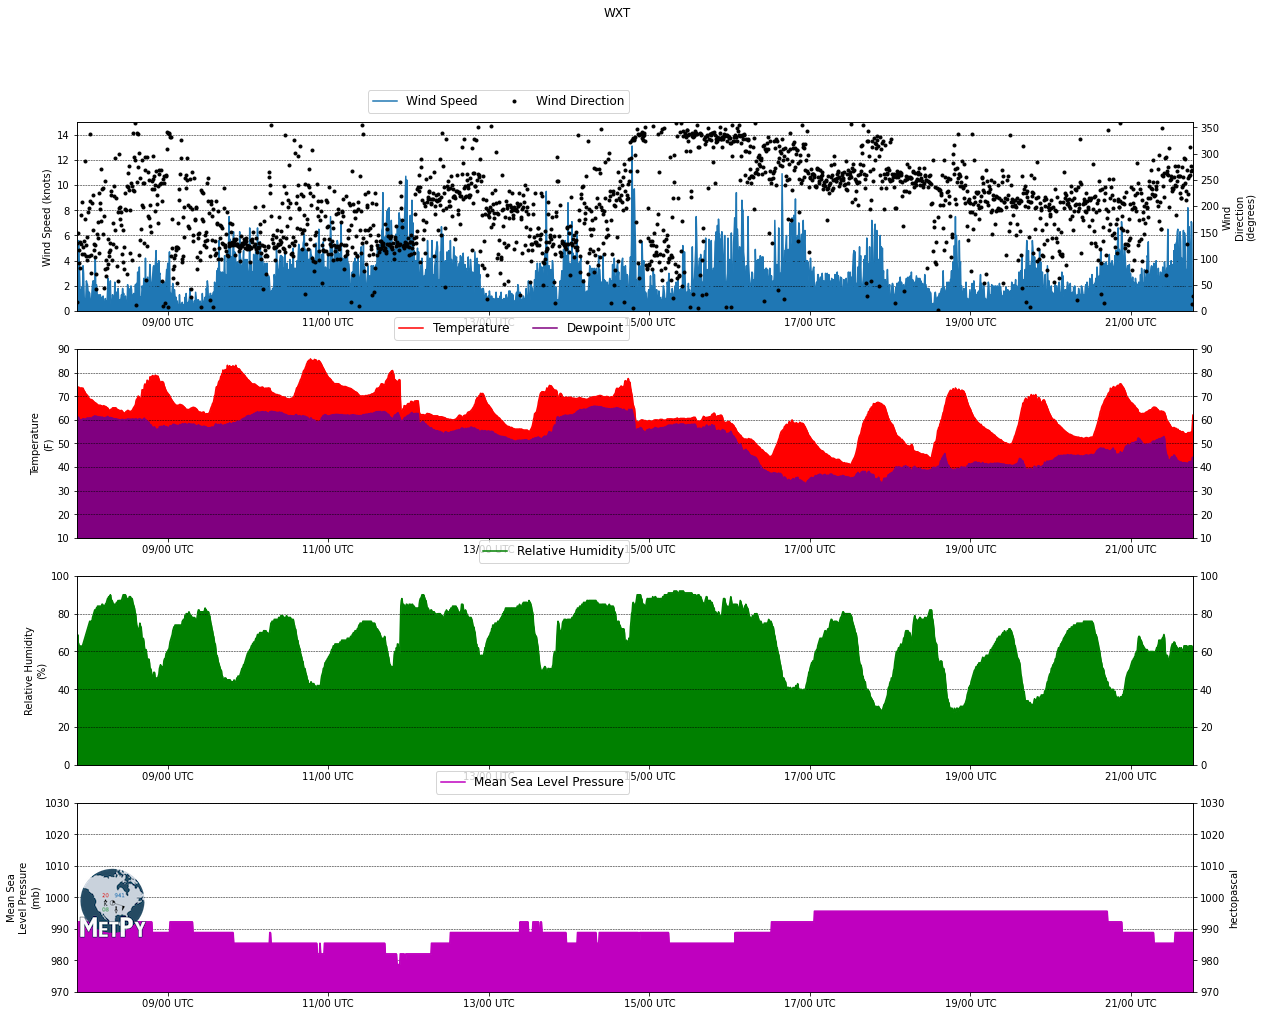

In [9]:
fig = plt.figure(figsize=(20, 16))
add_metpy_logo(fig, 75, 75)
meteogram = Meteogram(fig, wxt['Date/Time'].values.squeeze(), 'WXT')
meteogram.plot_winds(wxt['WindSp'].values.squeeze() * units(wxt.units['WindSp']), 
                     wxt['WindDir'].values.squeeze() * units(wxt.units['WindDir']),
                     wxt['WindSp'].values.squeeze() * units(wxt.units['WindSp']))
meteogram.plot_thermo((wxt['AirTemp'].values.squeeze() * units(wxt.units['AirTemp'])).to(units('degF')), 
                      (wxt['Dewpoint'].values.squeeze() * units(wxt.units['Dewpoint'])).to(units('degF')))
meteogram.plot_rh(wxt['RH'].values.squeeze())
meteogram.plot_pressure(wxt['BP'].values.squeeze() * units(wxt.units['BP']).to(units('hPa')))
plt.suptitle('WXT')
plt.savefig(fileName[:-3] + 'png')

# What does the meteogram from KLAF look like over this same period?
Since this time period exceeds the 120-hour limit of the FAA METAR web site, we'll use the Iowa State Environmental mesonet instead.
https://mesonet.agron.iastate.edu/request/download.phtml<br>
0) Under "Select Network", choose "Indiana ASOS", then click "Switch Network"<br>
1) Add "LAF" to the list of selected stations.<br>
2) Select "Raw METAR"</br>
3) Select the period 7-21 October 2021<br>
4) Leave unchanged.<br>
5) Select "Save result data to file on computer" in the last pull-down menu; otherwise leave unchanged.<br>
6) Select both types of METARs.<br>
7) Click "Get Data". Save the file (which will be called "LAF.txt") to your machine, then upload it in this directory.

Let's read it in:

In [12]:
laf = pd.read_csv("LAF.csv")
laf

,station,valid,metar
0,LAF,2021-10-07 00:00,KLAF 070000Z AUTO 07005KT 10SM BKN046 21/19 A3...
1,LAF,2021-10-07 00:05,KLAF 070005Z AUTO 07005KT 10SM BKN046 OVC055 2...
2,LAF,2021-10-07 00:10,KLAF 070010Z AUTO 08007KT 10SM BKN048 OVC055 2...
3,LAF,2021-10-07 00:15,KLAF 070015Z AUTO 08008KT 9SM BKN045 OVC050 21...
4,LAF,2021-10-07 00:20,KLAF 070020Z AUTO 08007KT 9SM BKN045 OVC055 21...
...,...,...,...
4520,LAF,2021-10-20 23:40,KLAF 202340Z AUTO 21002KT 10SM CLR 19/11 A2996...
4521,LAF,2021-10-20 23:45,KLAF 202345Z AUTO 19002KT 10SM CLR 19/11 A2996...
4522,LAF,2021-10-20 23:50,KLAF 202350Z AUTO 19004KT 10SM CLR 19/12 A2996...
4523,LAF,2021-10-20 23:54,KLAF 202354Z 19006KT 10SM CLR 19/12 A2997 RMK ...


Note that the METARs are a little bit different here: They're actually a column of strings in the dataframe. To parse them, we need to extract them from the data frame. For example, we can access the first METAR by typing:

In [13]:
laf.metar[0]

'KLAF 070000Z AUTO 07005KT 10SM BKN046 21/19 A3013 RMK T02100190 MADISHF'

We need to use another MetPy function, parse_metar_to_dataframe, to parse the METAR.
Note that I now have to specify the year and month, since we're in a month other than the one in which the data were collected (it's now November; the data were collected in October).

In [14]:
from metpy.io import parse_metar_to_dataframe
laf_metar = parse_metar_to_dataframe(laf.metar[0], year = 2021, month = 10)
laf_metar

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-07,70,5.0,16093.44,NaN,NaN,...,21.0,19.0,30.13,0,0,0,T02100190 MADISHF,1020.15,-4.698463,-1.710101


That's just the first METAR. Now we have to do the other 4,524.

In [15]:
for i in range(1, len(laf)):
    if i%100 == 0: print("Parsing METAR number ", i)
    tmp = parse_metar_to_dataframe(laf.metar[i], year = 2021, month = 10)
    laf_metar = pd.concat([laf_metar, tmp])
    
laf_metar

Parsing METAR number  100
Parsing METAR number  200
Parsing METAR number  300
Parsing METAR number  400
Parsing METAR number  500
Parsing METAR number  600
Parsing METAR number  700
Parsing METAR number  800
Parsing METAR number  900
Parsing METAR number  1000
Parsing METAR number  1100
Parsing METAR number  1200
Parsing METAR number  1300
Parsing METAR number  1400
Parsing METAR number  1500
Parsing METAR number  1600
Parsing METAR number  1700
Parsing METAR number  1800
Parsing METAR number  1900
Parsing METAR number  2000
Parsing METAR number  2100
Parsing METAR number  2200
Parsing METAR number  2300
Parsing METAR number  2400
Parsing METAR number  2500
Parsing METAR number  2600
Parsing METAR number  2700
Parsing METAR number  2800
Parsing METAR number  2900
Parsing METAR number  3000
Parsing METAR number  3100
Parsing METAR number  3200
Parsing METAR number  3300
Parsing METAR number  3400
Parsing METAR number  3500
Parsing METAR number  3600
Parsing METAR number  3700
Parsing ME

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:00:00,70.0,5.0,16093.440,NaN,NaN,...,21.0,19.0,30.13,0,0,0,T02100190 MADISHF,1020.15,-4.698463e+00,-1.710101
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:05:00,70.0,5.0,16093.440,NaN,NaN,...,21.0,19.0,30.13,0,0,0,T02100190 MADISHF,1020.15,-4.698463e+00,-1.710101
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:10:00,80.0,7.0,16093.440,NaN,NaN,...,21.0,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-6.893654e+00,-1.215537
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:15:00,80.0,8.0,14484.096,NaN,NaN,...,21.0,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-7.878462e+00,-1.389185
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:20:00,80.0,7.0,14484.096,NaN,NaN,...,21.0,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-6.893654e+00,-1.215537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:40:00,210.0,2.0,16093.440,NaN,NaN,...,19.0,11.0,29.96,0,0,0,T01900110 MADISHF,1014.52,1.000000e+00,1.732051
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:45:00,190.0,2.0,16093.440,NaN,NaN,...,19.0,11.0,29.96,0,0,0,T01900110 LTG DSNT NW! MADISHF,1014.52,3.472964e-01,1.969616
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:50:00,190.0,4.0,16093.440,NaN,NaN,...,19.0,12.0,29.96,0,0,0,T01900120 LTG DSNT NW! MADISHF,1014.52,6.945927e-01,3.939231


Remember that we need to add a units attribute to this Dataframe:

In [16]:
# Assign units to each column in the dataframe.
laf_metar.units = \
{'station_id': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meters',
 'date_time': None,
 'wind_direction': 'degrees',
 'wind_speed': 'kts',
 'eastward_wind': 'kts',
 'northward_wind': 'kts',
 'current_wx1': None,
 'current_wx2': None,
 'current_wx3': None,
 'low_cloud_type': None,
 'low_cloud_level': 'feet',
 'medium_cloud_type': None,
 'medium_cloud_level': 'feet',
 'high_cloud_type': None,
 'high_cloud_level': 'feet',
 'highest_cloud_type': None,
 'highest_cloud_level:': None,
 'cloud_coverage': None,
 'air_temperature': 'degC',
 'dew_point_temperature': 'degC',
 'altimeter': 'inHg',
 'air_pressure_at_sea_level': 'hPa',
 'present_weather': None,
 'past_weather': None,
 'past_weather2': None,
 'rh' : None}

And we also need to calculate humidity

In [17]:
from metpy.calc import relative_humidity_from_dewpoint
laf_metar['rh'] = relative_humidity_from_dewpoint(laf_metar.air_temperature.values * units(laf_metar.units['air_temperature']), 
                      laf_metar.dew_point_temperature.values * units(laf_metar.units['dew_point_temperature']))
laf_metar

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind,rh
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:00:00,70.0,5.0,16093.440,NaN,NaN,...,19.0,30.13,0,0,0,T02100190 MADISHF,1020.15,-4.698463e+00,-1.710101,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:05:00,70.0,5.0,16093.440,NaN,NaN,...,19.0,30.13,0,0,0,T02100190 MADISHF,1020.15,-4.698463e+00,-1.710101,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:10:00,80.0,7.0,16093.440,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-6.893654e+00,-1.215537,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:15:00,80.0,8.0,14484.096,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-7.878462e+00,-1.389185,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:20:00,80.0,7.0,14484.096,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.49,-6.893654e+00,-1.215537,0.883433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:40:00,210.0,2.0,16093.440,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 MADISHF,1014.52,1.000000e+00,1.732051,0.597358
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:45:00,190.0,2.0,16093.440,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 LTG DSNT NW! MADISHF,1014.52,3.472964e-01,1.969616,0.597358
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:50:00,190.0,4.0,16093.440,NaN,NaN,...,12.0,29.96,0,0,0,T01900120 LTG DSNT NW! MADISHF,1014.52,6.945927e-01,3.939231,0.638222


You will also note that the field air_pressure_at_sea_level is all NaNs. We need to calculate it from the station pressure and elevation, replacing the NaNs with MSLP values. See:
https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.altimeter_to_sea_level_pressure.html

In [18]:
from metpy.calc import altimeter_to_sea_level_pressure
altimeter_to_sea_level_pressure?

In [19]:
laf_metar['air_pressure_at_sea_level'] = altimeter_to_sea_level_pressure(
    laf_metar['altimeter'].values * units(laf_metar.units['altimeter']),
    laf_metar['elevation'].values * units(laf_metar.units['elevation']),
    laf_metar['air_temperature'].values * units(laf_metar.units['air_temperature'])).to(units('hPa'))
laf_metar

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind,rh
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:00:00,70.0,5.0,16093.440,NaN,NaN,...,19.0,30.13,0,0,0,T02100190 MADISHF,1020.148728,-4.698463e+00,-1.710101,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:05:00,70.0,5.0,16093.440,NaN,NaN,...,19.0,30.13,0,0,0,T02100190 MADISHF,1020.148728,-4.698463e+00,-1.710101,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:10:00,80.0,7.0,16093.440,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.488603,-6.893654e+00,-1.215537,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:15:00,80.0,8.0,14484.096,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.488603,-7.878462e+00,-1.389185,0.883433
KLAF,KLAF,40.42,-86.93,182,2021-10-07 00:20:00,80.0,7.0,14484.096,NaN,NaN,...,19.0,30.14,0,0,0,T02100190 MADISHF,1020.488603,-6.893654e+00,-1.215537,0.883433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:40:00,210.0,2.0,16093.440,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 MADISHF,1014.517707,1.000000e+00,1.732051,0.597358
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:45:00,190.0,2.0,16093.440,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 LTG DSNT NW! MADISHF,1014.517707,3.472964e-01,1.969616,0.597358
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:50:00,190.0,4.0,16093.440,NaN,NaN,...,12.0,29.96,0,0,0,T01900120 LTG DSNT NW! MADISHF,1014.517707,6.945927e-01,3.939231,0.638222


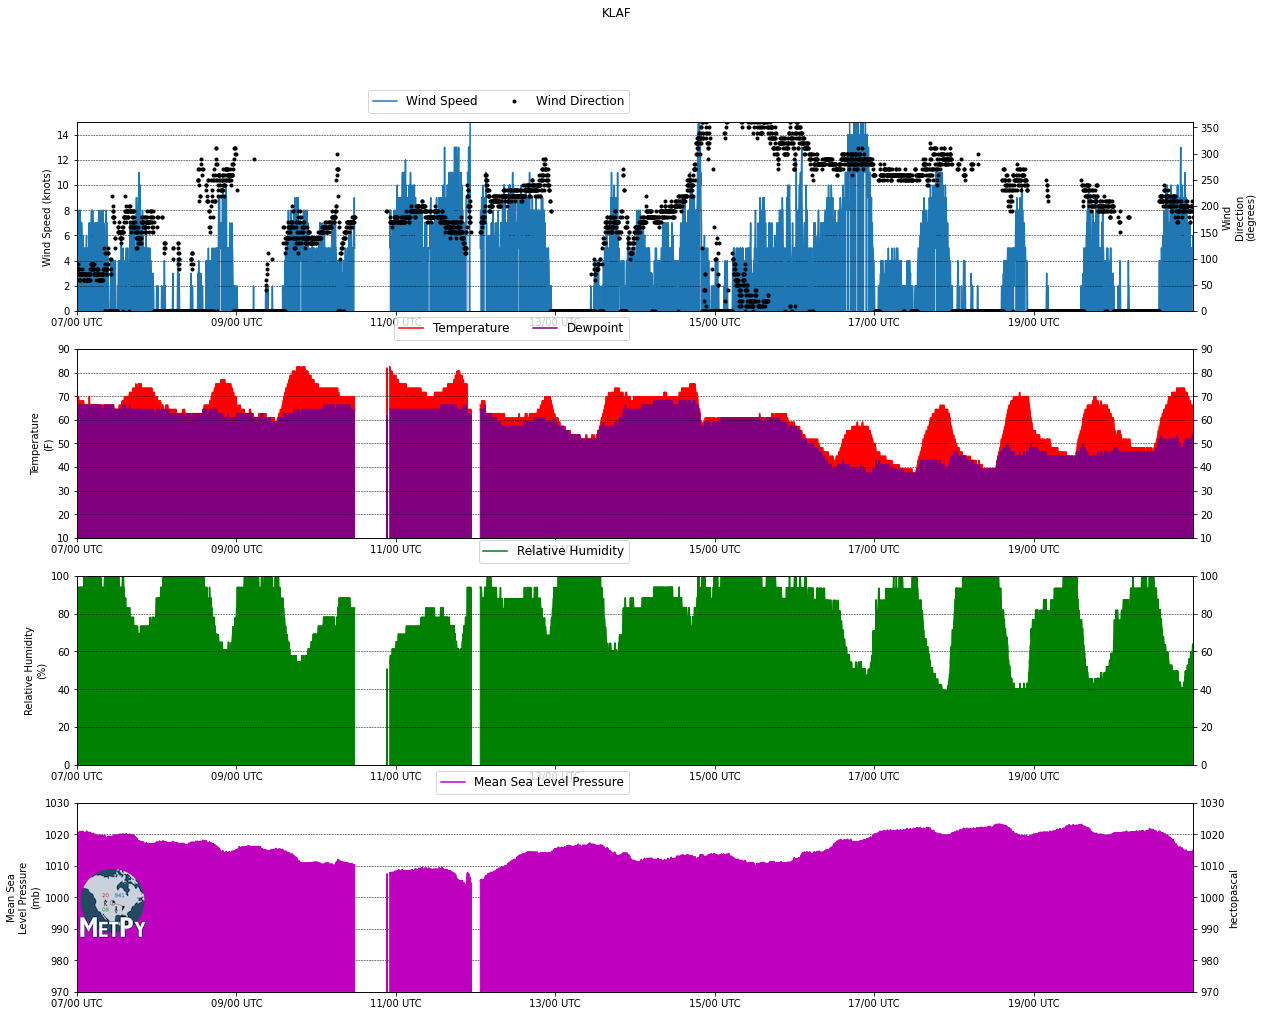

In [20]:
fig = plt.figure(figsize=(20, 16))
add_metpy_logo(fig, 75, 75)
meteogram = Meteogram(fig, laf_metar.date_time.values, laf_metar.station_id[0])
meteogram.plot_winds(laf_metar.wind_speed.values * units(laf_metar.units['wind_speed']), 
                     laf_metar.wind_direction.values * units(laf_metar.units['wind_direction']),
                     laf_metar.wind_speed.values * units(laf_metar.units['wind_speed']))
meteogram.plot_thermo((laf_metar.air_temperature.values * units(laf_metar.units['air_temperature'])).to(units('degF')), 
                      (laf_metar.dew_point_temperature.values * units(laf_metar.units['dew_point_temperature'])).to(units('degF')))
meteogram.plot_rh(laf_metar.rh.values*100.)
meteogram.plot_pressure(laf_metar.air_pressure_at_sea_level.values * units(laf_metar.units['air_pressure_at_sea_level']))
plt.suptitle(laf_metar.station_id[0])
plt.savefig('LAF.png')

# Part Deux: Calculating bias.

For this section, we'll treat the (presumably) well-calibrated KLAF data as "truth", and the WXT data as "test" data.

## List the times of some of the WXT and KLAF data. 
They don't quite match up.

The function "head" prints out the top five entries of a DataFrame.

In [21]:
wxt.loc[wxt['Date/Time'] > pd.datetime(2021,10,8)].head()

,Date/Time,WindDir,WindSp,AirTemp,RH,BP,RainInten,Dewpoint
20,2021-10-08 00:10:00,189,1.6,69.8,73,29.3,0.0,15.979978
21,2021-10-08 00:20:00,105,1.5,69.4,74,29.3,0.0,15.978839
22,2021-10-08 00:30:00,196,1.5,69.0,75,29.3,0.0,15.974482
23,2021-10-08 00:40:00,209,1.4,68.7,76,29.3,0.0,16.020714
24,2021-10-08 00:50:00,337,0.8,68.7,76,29.3,0.0,16.020714


In [22]:
laf_metar.loc[laf_metar['date_time'] > pd.datetime(2021,10,8)].head()

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind,rh
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-08 00:05:00,180.0,2.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02100180 MADISHF,1017.089868,-2.449294e-16,2.0,0.829759
KLAF,KLAF,40.42,-86.93,182,2021-10-08 00:10:00,0.0,0.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02000180 MADISHF,1017.163211,-0.000000e+00,-0.0,0.882598
KLAF,KLAF,40.42,-86.93,182,2021-10-08 00:15:00,0.0,0.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02000180 MADISHF,1017.163211,-0.000000e+00,-0.0,0.882598
KLAF,KLAF,40.42,-86.93,182,2021-10-08 00:20:00,0.0,0.0,16093.44,NaN,NaN,...,18.0,30.05,0,0,0,T02000180 MADISHF,1017.503107,-0.000000e+00,-0.0,0.882598
KLAF,KLAF,40.42,-86.93,182,2021-10-08 00:25:00,180.0,2.0,16093.44,NaN,NaN,...,18.0,30.05,0,0,0,T02000180 MADISHF,1017.503107,-2.449294e-16,2.0,0.882598


# Pro tip: Typically, we downsample the more frequent data to match the less frequent data.
The KLAF DataFrame has about 4500 rows, while the WXT data has only about 2500. Therefore, we'll downsample the KLAF data to match the times of the WXT data. 

I use two DataFrame built-in functions to do this: isin(), which queries whether the times are present in both DataFrames, and drop_duplicates(), which does just what it says.

In [23]:
laf_metar = laf_metar[laf_metar['date_time'].isin(wxt['Date/Time'])].drop_duplicates(subset=['date_time']).dropna(subset = ['air_temperature'])
laf_metar

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind,rh
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-10-07 20:50:00,170.0,2.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02300180 MADISHF,1016.944685,-3.472964e-01,1.969616,0.734401
KLAF,KLAF,40.42,-86.93,182,2021-10-07 21:00:00,180.0,5.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02300180 MADISHF,1016.944685,-6.123234e-16,5.000000,0.734401
KLAF,KLAF,40.42,-86.93,182,2021-10-07 21:10:00,170.0,5.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02300180 MADISHF,1016.944685,-8.682409e-01,4.924039,0.734401
KLAF,KLAF,40.42,-86.93,182,2021-10-07 21:20:00,160.0,5.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02300180 MADISHF,1016.944685,-1.710101e+00,4.698463,0.734401
KLAF,KLAF,40.42,-86.93,182,2021-10-07 21:30:00,170.0,5.0,16093.44,NaN,NaN,...,18.0,30.04,0,0,0,T02300180 MADISHF,1016.944685,-8.682409e-01,4.924039,0.734401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:10:00,190.0,5.0,16093.44,NaN,NaN,...,11.0,29.95,0,0,0,T02000110 MADISHF,1014.104162,8.682409e-01,4.924039,0.561331
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:20:00,200.0,5.0,16093.44,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 LTG DSNT NW! MADISHF,1014.517707,1.710101e+00,4.698463,0.597358
KLAF,KLAF,40.42,-86.93,182,2021-10-20 23:30:00,200.0,4.0,16093.44,NaN,NaN,...,11.0,29.96,0,0,0,T01900110 LTG DSNT NW! MADISHF,1014.517707,1.368081e+00,3.758770,0.597358


We've reduced the size of the laf_metar DataFrame from about 4500 rows to about 1800.

We'll run the same isin() function on our WXT DataFrame to get rid of any rows with times that aren't in the KLAF DataFrame. The result should be two DataFrames with the same length.

In [24]:
wxt = wxt[wxt['Date/Time'].isin(laf_metar['date_time'])]
wxt

,Date/Time,WindDir,WindSp,AirTemp,RH,BP,RainInten,Dewpoint
0,2021-10-07 20:50:00,18,0.3,68.0,60,29.3,0.0,12.006808
1,2021-10-07 21:00:00,129,3.6,71.7,69,29.3,0.0,16.110036
2,2021-10-07 21:10:00,149,1.2,73.7,65,29.3,0.0,16.232131
3,2021-10-07 21:20:00,116,5.6,73.9,64,29.3,0.0,16.094479
4,2021-10-07 21:30:00,92,3.9,73.7,62,29.3,0.0,15.493365
...,...,...,...,...,...,...,...,...
1886,2021-10-20 23:10:00,126,1.9,69.0,49,29.2,0.0,9.480414
1887,2021-10-20 23:20:00,136,3.3,68.7,50,29.2,0.0,9.627927
1888,2021-10-20 23:30:00,176,3.7,68.3,50,29.2,0.0,9.423451
1889,2021-10-20 23:40:00,139,2.4,68.0,51,29.2,0.0,9.564490


Voila!

# Now, we can calculate some biases!

# Let's make a scatterplot for temperature.

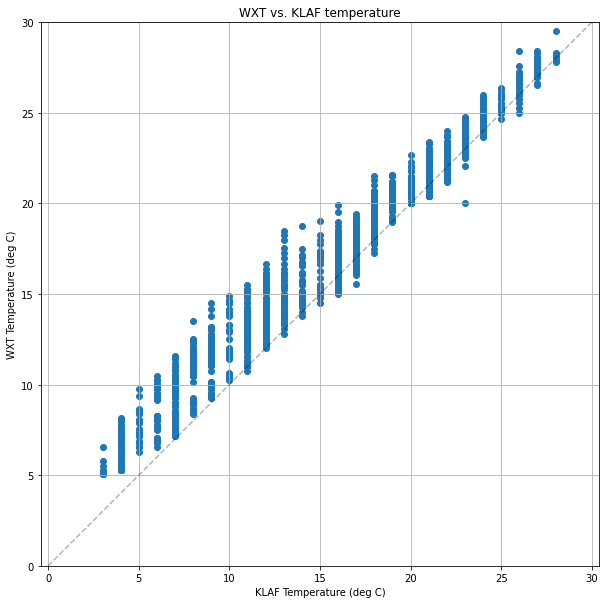

In [25]:
test = (wxt['AirTemp'].values * units('degF')).to(units('degC'))
truth = laf_metar['air_temperature'].values * units('degC')

fig = plt.figure(figsize = (10, 10))
# Scatterplot of WXT vs KLAF temperature data
# Note that I have to 
plt.scatter(truth, test)
# Plot 1:1 line
plt.plot(np.arange(0, 31), np.arange(0, 31), 'k--', alpha = 0.3)
plt.axis('equal') 
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('KLAF Temperature (deg C)')
plt.ylabel('WXT Temperature (deg C)')
plt.title('WXT vs. KLAF temperature')
plt.grid()

We have a slight issue with KLAF data being rounded to the nearest whole degree Celsius... but there's not much we can do about it. 

# Let's calculate the temperature bias.

# Recall that the equation for bias $\bar{\varepsilon}$ is:

# $\bar{\varepsilon}=\frac{1}{N} \sum_{i=1}^{N} \varepsilon_{i}$

where $\varepsilon_{i}$ is the <i>error</i> (WXT minus KLAF) associated with the <i>i</i>th measurement, and N = 1889 is the total number of measurements. 

In [26]:
error = test - truth
print('Error = ', error) # print error values to the screen

N = len(test)
print('N = ', N)

bias = (1 / N) * np.nansum(error)
print('Bias = ', bias)

Error =  [-2.999999999999943 -0.9444444444444002 0.16666666666668561 ... 1.1666666666666856 1.0000000000000568 0.7777777777778283] delta_degree_Celsius
N =  1812
Bias =  1.1228231542801472 delta_degree_Celsius


# 1. What is the bias of the WXT temperature sensor? Enter your answer on Brightspace.

Let's subtract that bias.

In [27]:
test = test - bias

Now, redo the scatterplot, noting that there are about as many points above the 1:1 line as below now.

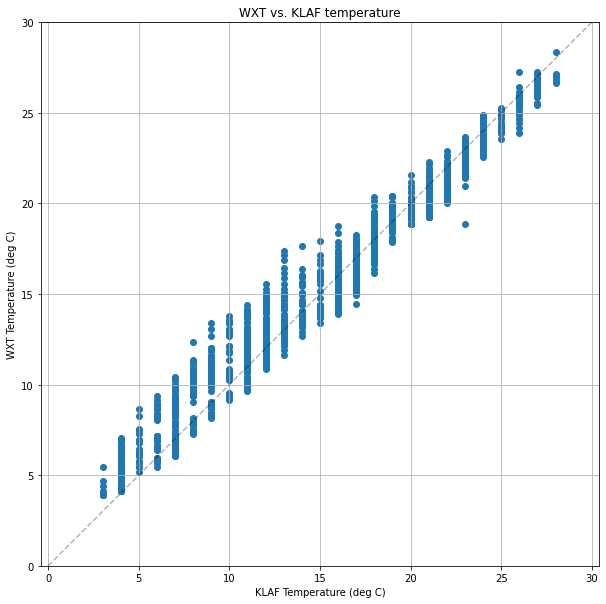

In [28]:
fig = plt.figure(figsize = (10, 10))
# Scatterplot of WXT vs KLAF temperature data
# Note that I have to 
plt.scatter(truth, test)
# Plot 1:1 line
plt.plot(np.arange(0, 31), np.arange(0, 31), 'k--', alpha = 0.3)
plt.axis('equal') 
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('KLAF Temperature (deg C)')
plt.ylabel('WXT Temperature (deg C)')
plt.title('WXT vs. KLAF temperature')
plt.grid()

# Now that we've removed the bias, let's quantify the WXT's uncertainty.

### The equation for uncertainty $\sigma_{\varepsilon}$ is:

# $\sigma_{\varepsilon}=\sqrt{\frac{1}{N-1} \sum_{i=1}^{N}\left(\varepsilon_{i}-\bar{\varepsilon}\right)^{2}}$

In Python code, this equation becomes:

In [29]:
uncertainty = np.sqrt( (1 / (N - 1)) * np.nansum((error - bias) ** 2.) )
print('Uncertainty = ', uncertainty)

Uncertainty =  1.2618536733897632 delta_degree_Celsius


# 2. What is the WXT temperature sensor's uncertainty? (Include units)

# 3. Find the ASOS user's guide online, and look up the root mean squared error (RMSE) associated with the ASOS temperature sensor for its typical operating range. How does it compare with the uncertainty you calculated above? 

Enter your answers on Brightspace!

# Graphically, what do these temperature distributions look like?
Note: You will need to convert the RMSE from degrees F to degrees C!

In [30]:
# Enter the ASOS RMSE here in degrees F:
asos_rmse = 0.9
(asos_rmse * units('delta_degree_Fahrenheit')).to('delta_degree_Celsius')

0.5 <Unit('delta_degree_Celsius')>

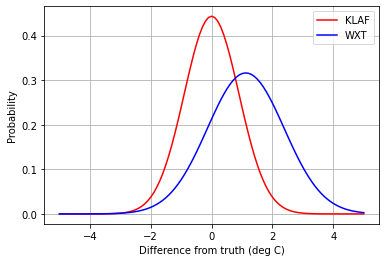

In [31]:
t = np.arange(-5, 5.1, 0.1) # Range of temperature differences over which to plot
# Plot the "truth" (KLAF) temperature distribution
plt.plot(t, stats.norm.pdf(t, 0, asos_rmse), 'r', label  = 'KLAF')
# Plot the "test" (WXT) temperature distribution
plt.plot(t, stats.norm.pdf(t, bias, uncertainty), 'b', label = 'WXT')
plt.grid()
plt.xlabel('Difference from truth (deg C)')
plt.ylabel('Probability')
h = plt.legend()

# Lastly, compare the uncertainty you found with the manufacturer-stated accuracy (uncertainty) of the WXT data.
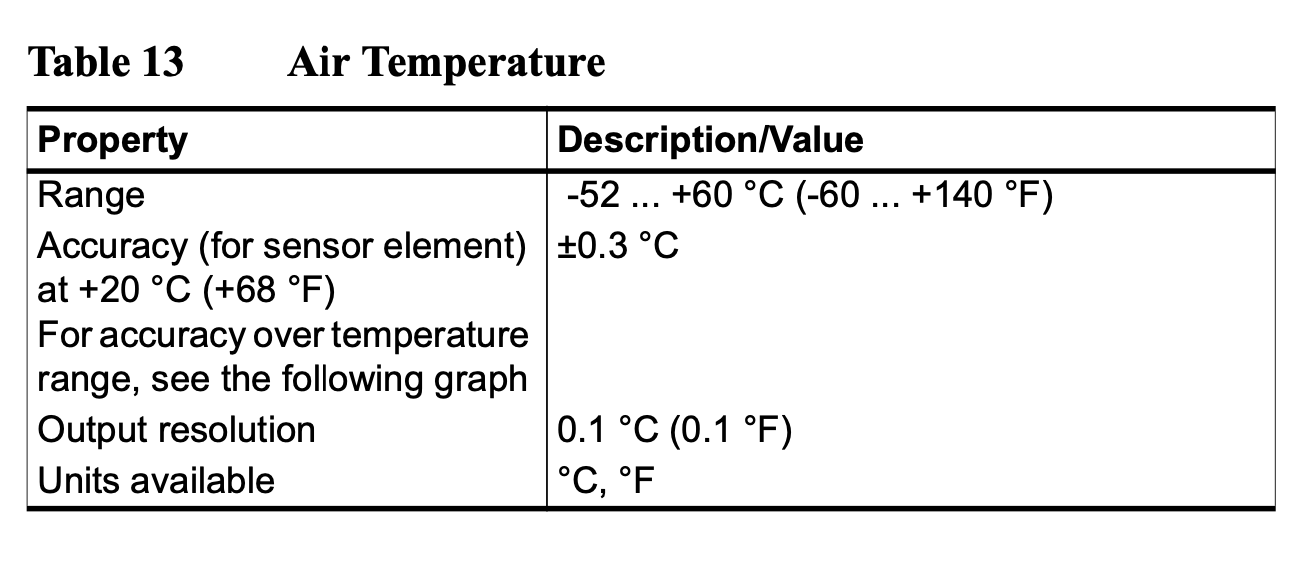

# 4. Is there a discrepancy between the manufacturer reported and calculated WXT accuracy? Why do you think that is?
Enter your answer on Brightspace.